In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
#for ipynb
%matplotlib inline
import yaml

In [2]:
#get list of files with data
in_dirs = ['../TFBS_nucleosome_profiling_unfiltered_v2/results',
           '../TFBS_nucleosome_profiling_unfiltered_30000sites_v2/results',
           '../TFBS_nucleosome_profiling_unfiltered_50000sites_v2/results']

samples_yaml = '../TFBS_nucleosome_profiling_unfiltered_v2/config/samples.GC.yaml'
tfx_path = '../../metadata/delfi/analysis/Delfi_tumor_fraction_data.txt'
metadata_path = '../../../griffin_paper/data/delfi_metadata/analysis/matched_metadata_corrected.txt'

with open(samples_yaml, 'r') as f:
    samples = yaml.safe_load(f)
samples = samples['samples']
samples = list(samples.keys())  
print('samples:',len(samples))  



samples: 423


In [3]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [4]:
#get the metadata
metadata1 = pd.read_csv(metadata_path, sep='\t')
metadata1 = metadata1[['new_sample_name','Stage','Age at Diagnosis', 'Gender']].set_index('new_sample_name') 
metadata2 = pd.read_csv(tfx_path, sep='\t')
metadata2 = metadata2[['sample','tfx','sample_type']].set_index('sample') 
metadata = metadata1.merge(metadata2, left_index = True, right_index=True)
metadata = metadata.reset_index()
metadata = metadata.rename(columns = {'tfx':'tumor_fraction','index':'sample'})
metadata['status'] = np.where(metadata['sample_type'].str.contains('ancer'),1,0)
metadata['Stage'] = metadata['Stage'].str.strip(' ')

metadata_columns = ['sample','tumor_fraction','status','sample_type','Stage','Age at Diagnosis', 'Gender']
metadata = metadata[metadata_columns]
print("metadata:",len(metadata))

metadata: 423


In [5]:
for in_dir in in_dirs:
    in_files = []
    for sample in samples:
        in_files.append(in_dir+'/'+sample+'/'+sample+'.GC_corrected.coverage.tsv')
    print('files to import',len(in_files))    
    
    #import data
    start_time = time.time()
    data = pd.DataFrame()
    for i,file in enumerate(in_files):
        if i%100==0:
            print(i,'importing',file,np.round(time.time()-start_time))
        current = pd.read_csv(file,sep='\t')
        data = data.append(current, ignore_index=True)
    
    #add site group
    data['site_group'] = data['site_name'].str.rsplit('.',1,expand = True)[1]+'-sites'
    
    #merge with metadata
    data = data.merge(metadata, on = 'sample')
    data['Stage'] = data['Stage'].str.strip('ABC')
    print('data with metadata:')
    print(len(data['site_name'].unique()))
    print(len(data['sample'].unique()))
    print(len(data))
    print(len(data['site_name'].unique())*len(data['sample'].unique()))
    print(data['number_of_sites'].unique())

    #get the key columns
    data = data[metadata_columns+['site_name','site_group',
                                  'central_coverage','amplitude','mean_coverage']+str_plot_columns]

    #export each site group
    for group,df in data.groupby('site_group'):
        print(group,len(df['site_name'].unique()))

        df.to_csv('merged_data/'+group+'_data_with_features.txt', sep='\t', index=False)

        #reformat for logistic regression
        reformatted = df[metadata_columns+['site_name','site_group','central_coverage','amplitude','mean_coverage']]
        reformatted = reformatted.set_index(metadata_columns+['site_group','site_name']).unstack()
        new_column_names = []
        for item in reformatted.columns.values:
            new_column_names.append('_'.join(item))
        reformatted.columns = new_column_names

        reformatted.to_csv('merged_data/'+group+'_reformatted.txt', sep='\t')

        print(reformatted.shape)


files to import 423
0 importing ../TFBS_nucleosome_profiling_unfiltered_v2/results/Bile_Duct_Cancer_CGPLPA114/Bile_Duct_Cancer_CGPLPA114.GC_corrected.coverage.tsv 0.0
100 importing ../TFBS_nucleosome_profiling_unfiltered_v2/results/Colorectal_Cancer_CGCRC321/Colorectal_Cancer_CGCRC321.GC_corrected.coverage.tsv 6.0
200 importing ../TFBS_nucleosome_profiling_unfiltered_v2/results/Healthy_CGPLH365/Healthy_CGPLH365.GC_corrected.coverage.tsv 24.0
300 importing ../TFBS_nucleosome_profiling_unfiltered_v2/results/Healthy_CGPLH479/Healthy_CGPLH479.GC_corrected.coverage.tsv 52.0
400 importing ../TFBS_nucleosome_profiling_unfiltered_v2/results/Pancreatic_Cancer_CGPLPA37/Pancreatic_Cancer_CGPLPA37.GC_corrected.coverage.tsv 84.0
data with metadata:
1705
423
721215
721215
[20000 10000  5000  1000]
1000-sites 566
(423, 1698)
10000-sites 377
(423, 1131)
20000-sites 316
(423, 948)
5000-sites 446
(423, 1338)
files to import 423
0 importing ../TFBS_nucleosome_profiling_unfiltered_30000sites_v2/results/Bi

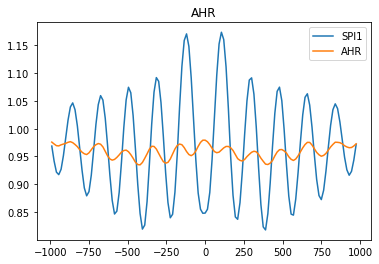

In [6]:
#plot
for site_name in ['SPI1','AHR']:
    current = data[data['site_name'].str.contains(site_name)][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    plt.title(site_name)
    #plt.show()
plt.legend()



fft real -0.24439368209168288
fft imag -0.1871432009846839
fft magn 0.3078162593514585
sum x coords -0.24439368209169654
sum y coords -0.18714320098470832
magnitude: 0.30781625935148416


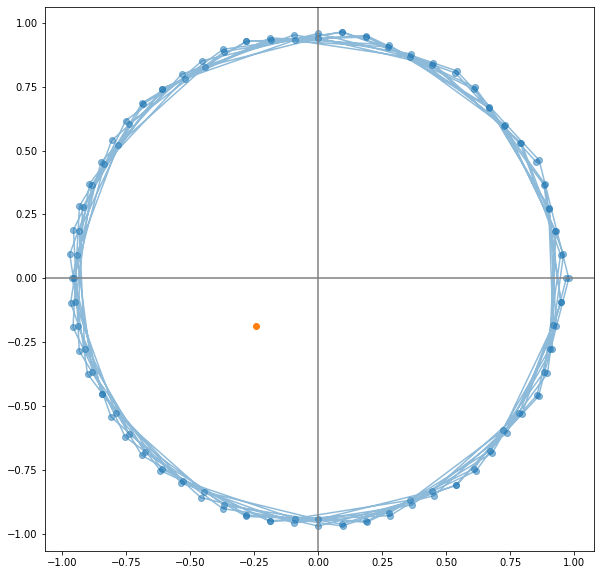

In [7]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [8]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)